# Basic 1D test

This loads a 1D dataset, without errors, and does a simple least-squares fit to it. It checks that the
data can be unsorted, and does some simple multiple-dataset fits.

Note that I had thought that the "seeing the logging output twice, with one version with a pink background" had
been fixed, but obviously not.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
# Fixing the random seed is an attempt to make the following test more deterministic,
# but it's not ideal since there's no guarantee that the results will be the same
# on different architectures, or different versions of NumPy.
np.random.seed(23742)

In [3]:
from sherpa import ui
from sherpa.utils import err

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [4]:
import logging

logger = logging.getLogger('sherpa')

class Assert:
    """Rather hacky set of assertions"""
    
    def __init__(self):
        self.ntests = 0
        self.fails = []
        
    def __str__(self):
        return "Num tests={}  num failed={}".format(self.ntests, len(self.fails))
    
    def report(self, ntot=None):
        if ntot is not None and self.ntests != ntot:
            print("Expected {} tests but ran {}".format(ntot, self.ntests))
            
        if self.ntests == 0:
            print("No tests ran")
            return
        if self.fails == []:
            print("All {} tests ran successfully".format(self.ntests))
            return
        print("Out of {} tests, the following {} failed:".format(self.ntests, len(self.fails)))
        for f in self.fails:
            print("  {}".format(f))
            
    def assertTrue(self, f, msg=None):
        """Log a message if the assertion is False."""
        self.ntests += 1
        if f: return
        if msg is None: msg = "assertion failed"
        self.fails.append(msg)
        logger.error(msg)
    
    def assertEqual(self, exp, got, msg=None):
        """Check that got equals exp"""
        if msg is None:
            msg = ""
        else:
            msg += ": "
        msg += "Expected {} but got {}".format(exp, got)
        # Hack
        res = exp == got
        try:
            res = res.all()
        except AttributeError:
            pass
        self.assertTrue(res, msg)
    
    def assertEqualTol(self, exp, got, tol=1e-7, msg=None):
        """Simple absolute tolerance check"""
        if msg is None:
            msg = ""
        else:
            msg += ": "
        msg += "Absolute tolerance of {} exceeded: {} vs {}".format(tol, exp, got)
        res = np.abs(got - exp) > tol
        try:
            res = res.any()
        except AttributeError:
            pass
        self.assertTrue(not res, msg=msg)

In [5]:
t = Assert()

## Data to be used

A polynomial form is used, and the data is not assumed to be ordered. Note that while Sherpa can fit unordered data, the plot routines may not work correctly.

In [6]:
npts = 50
sigma = 10
a0 = 13.2
a1 = -1.9
a2 = 0.027
x = np.random.random(size=npts) * 100 + 50
y = a0 + a1 * x + a2 * x * x + np.random.normal(scale=sigma, size=npts)

In [7]:
# these were determined by comparing the fit result to the input value, and so are "regression" tests
# (i.e. just check that get similar results when it is re-run)
a0_fit = 11.728
a0_tol = 0.001

a1_fit = -1.854
a1_tol = 0.001

a2_fit = 0.027
a2_tol = 0.001

In [8]:
ui.load_arrays(1, x, y)

In [9]:
# Can we access the data?
d = ui.get_data()
print(d)

name      = 
x         = Float64[50]
y         = Float64[50]
staterror = None
syserror  = None


In [10]:
t.assertTrue(isinstance(d, ui.Data1D), "data is Data1D")

In [11]:
t.assertEqual(x, d.x, "x array")

In [12]:
t.assertEqual(y, d.y, "y array")

In [13]:
t.assertEqual(None, d.staterror, "staterror")

In [14]:
t.assertEqual(None, d.syserror, "syserror")

In [15]:
t.assertEqual('chi2gehrels', ui.get_stat_name())

In [16]:
# Ignore error bars in the fit
ui.set_stat('leastsq')

In [17]:
t.assertEqual('leastsq', ui.get_stat_name())

/home/djburke/miniconda2/envs/sherpa-4.8.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


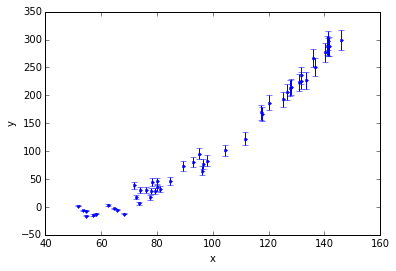

In [18]:
# Expect to get a warning message about the error bars
ui.plot_data()

In [19]:
flag = False
try:
    ui.get_source()
except err.IdentifierErr:
    flag = True

t.assertTrue(flag, "get_source did not error out")

In [20]:
ui.set_source(ui.polynom1d.mdl)

In [21]:
src = ui.get_source()

In [22]:
# Rely on whatever equality checking is provided by the model class
t.assertEqual(mdl, src)

In [23]:
t.assertEqual([1.0], src.thawedpars, "thawed parameters")

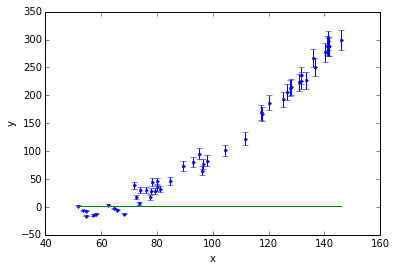

In [24]:
# Should be terrible
ui.plot_fit()

In [25]:
print(mdl)

polynom1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.c0       thawed            1 -3.40282e+38  3.40282e+38           
   mdl.c1       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c2       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c3       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c4       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c5       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c6       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c7       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c8       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.offset   frozen            0 -3.40282e+38  3.40282e+38           


In [26]:
pr = ui.get_model_plot()

In [27]:
t.assertEqual(x, pr.x)

In [28]:
# Model evaluation should be 1 for each bin
t.assertEqual(np.ones_like(x), pr.y)

In [29]:
stat_val_got = ui.calc_stat()

In [30]:
# The expected statistic can be easily calculated
stat_val_exp = ((y - 1)**2).sum()

In [31]:
t.assertEqualTol(stat_val_exp, stat_val_got)

In [32]:
t.assertTrue("levmar", ui.get_method_name())

In [33]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 1.17359e+06
Final fit statistic   = 570162 at function evaluation 4
Data points           = 50
Degrees of freedom    = 49
Change in statistic   = 603432
   mdl.c0         110.857     


INFO:sherpa.ui.utils:Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 1.17359e+06
Final fit statistic   = 570162 at function evaluation 4
Data points           = 50
Degrees of freedom    = 49
Change in statistic   = 603432
   mdl.c0         110.857     


In [34]:
fr = ui.get_fit_results()

In [35]:
t.assertTrue(fr.succeeded, msg="first fit succeeded")
t.assertEqual('leastsq', fr.statname, msg="first fit uses leastsq")

In [36]:
# I expect an answer of 4, but in case of numerical differences or changes in the
# optimiser, allow a slightly-wider range
t.assertTrue(fr.nfev < 10, "fit ran quickly")

In [37]:
t.assertEqual(npts - 1, fr.dof, msg='fit dof')

In [38]:
# This is just testing the result is similar to the first time I ran this (i.e a
# tregression test)
c0_init_fit = 110.8573
t.assertEqualTol(c0_init_fit, mdl.c0.val, tol=1e-4, msg="fitted value (c0)")

In [39]:
stat_init_fit = 570161.802
t.assertEqualTol(stat_init_fit, fr.statval, tol=1e-3, msg="final fit statistic")

In [40]:
t.assertEqual(None, fr.rstat, msg="No reduced statistic value for least squares fitting")

## Check out guess

In [41]:
ui.guess()

In [42]:
print(mdl)

polynom1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.c0       thawed      141.735     -15.4976      298.967           
   mdl.c1       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c2       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c3       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c4       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c5       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c6       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c7       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c8       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.offset   frozen            0 -3.40282e+38  3.40282e+38           


In [43]:
par_exp = (y.min() + y.max()) / 2
t.assertEqualTol(par_exp, mdl.c0.val, msg='c0 after guess')

In [44]:
t.assertEqualTol(y.min(), mdl.c0.min, msg='c0.min after guess')

In [45]:
t.assertEqualTol(y.max(), mdl.c0.max, msg='c0.max after guess')

In [46]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 617832
Final fit statistic   = 570162 at function evaluation 4
Data points           = 50
Degrees of freedom    = 49
Change in statistic   = 47670.2
   mdl.c0         110.857     


INFO:sherpa.ui.utils:Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 617832
Final fit statistic   = 570162 at function evaluation 4
Data points           = 50
Degrees of freedom    = 49
Change in statistic   = 47670.2
   mdl.c0         110.857     


In [47]:
# Back to initial guess
t.assertEqualTol(c0_init_fit, mdl.c0.val, tol=1e-4, msg="fitted value (c0)")

In [48]:
t.assertEqualTol(stat_init_fit, fr.statval, tol=1e-3, msg="final fit statistic")

## Free up other parameters

In [49]:
mdl.c0 = 1

In [50]:
ui.thaw(mdl.c1)
mdl.c2.frozen = False

In [51]:
t.assertEqual([1.0, 0.0, 0.0], mdl.thawedpars)

In [52]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 1.17359e+06
Final fit statistic   = 4662.82 at function evaluation 16
Data points           = 50
Degrees of freedom    = 47
Change in statistic   = 1.16893e+06
   mdl.c0         11.7278     
   mdl.c1         -1.8543     
   mdl.c2         0.0267718   


INFO:sherpa.ui.utils:Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 1.17359e+06
Final fit statistic   = 4662.82 at function evaluation 16
Data points           = 50
Degrees of freedom    = 47
Change in statistic   = 1.16893e+06
   mdl.c0         11.7278     
   mdl.c1         -1.8543     
   mdl.c2         0.0267718   


In [53]:
fr = ui.get_fit_results()

In [54]:
t.assertTrue(fr.succeeded, 'fit 2 succeeded')

In [55]:
t.assertTrue(fr.nfev < 20, 'fit 2 was quite quick')

In [56]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 4662.82
Final fit statistic   = 4662.82 at function evaluation 4
Data points           = 50
Degrees of freedom    = 47
Change in statistic   = 0
   mdl.c0         11.7278     
   mdl.c1         -1.8543     
   mdl.c2         0.0267718   


INFO:sherpa.ui.utils:Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 4662.82
Final fit statistic   = 4662.82 at function evaluation 4
Data points           = 50
Degrees of freedom    = 47
Change in statistic   = 0
   mdl.c0         11.7278     
   mdl.c1         -1.8543     
   mdl.c2         0.0267718   


In [57]:
fr2 = ui.get_fit_results()

In [58]:
t.assertTrue(fr2.succeeded, 'fit 3 succeeded')

In [59]:
t.assertTrue(fr2.nfev < 10, 'fit 3 was quick')

In [60]:
t.assertTrue(not (fr == fr2), 'fit results are different')

In [61]:
# regression test
par3_stat_val = 4662.824352783388
t.assertEqualTol(par3_stat_val, fr2.statval, tol=1e-4, msg='fit 3 stat value')

In [62]:
t.assertEqual(npts - 3, fr2.dof, msg='fit 3 dof')

In [63]:
t.assertEqualTol(a0_fit, mdl.c0.val, tol=a0_tol, msg='fit 3: c0 value')
t.assertEqualTol(a1_fit, mdl.c1.val, tol=a1_tol, msg='fit 3: c1 value')
t.assertEqualTol(a2_fit, mdl.c2.val, tol=a2_tol, msg='fit 3: c2 value')

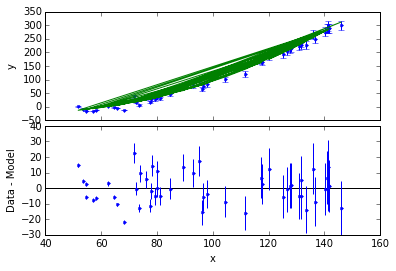

In [64]:
# It looks like this plot assumes that the data is ordered
ui.plot_fit_resid()

## Using the ordered version of the dataset

In [65]:
idx = np.argsort(x)
xsort = x[idx]
ysort = y[idx]

In [66]:
ui.load_arrays('sorted', xsort, ysort)

In [67]:
s1 = set([1, 'sorted'])
s2 = set(ui.list_data_ids())
t.assertEqual(s1, s2, msg='loaded data sets')

In [68]:
flag = False
try:
    ui.get_source('sorted')
except err.IdentifierErr:
    flag = True
    
t.assertTrue(flag, msg='no source for dataset=sorted')

In [69]:
t.assertEqual(d, ui.get_data(), msg='default dataset values unchanged')

In [70]:
d2 = ui.get_data('sorted')

In [71]:
t.assertTrue(not (d == d2), msg='datasets are different')

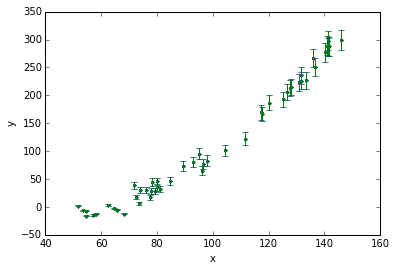

In [72]:
# The two data sets should be identical when plotted
ui.plot_data()
ui.plot_data('sorted', overplot=True)

In [73]:
ui.set_source('sorted', ui.polynom1d.mdl2)
ui.thaw(mdl2.c1, mdl2.c2)

In [74]:
m1 = set(['mdl', 'mdl2'])
m2 = set(ui.list_model_components())
t.assertEqual(m1, m2, msg='available model components')

In [75]:
ui.fit('sorted')

Dataset               = sorted
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 1.17359e+06
Final fit statistic   = 4662.82 at function evaluation 16
Data points           = 50
Degrees of freedom    = 47
Change in statistic   = 1.16893e+06
   mdl2.c0        11.7278     
   mdl2.c1        -1.8543     
   mdl2.c2        0.0267718   


INFO:sherpa.ui.utils:Dataset               = sorted
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 1.17359e+06
Final fit statistic   = 4662.82 at function evaluation 16
Data points           = 50
Degrees of freedom    = 47
Change in statistic   = 1.16893e+06
   mdl2.c0        11.7278     
   mdl2.c1        -1.8543     
   mdl2.c2        0.0267718   


In [76]:
fsort = ui.get_fit_results()

In [77]:
t.assertEqual(('sorted',), fsort.datasets, msg='fit was only to dataset=sorted')

In [78]:
t.assertTrue(fsort.succeeded, msg='fit to sorted was successful')

In [79]:
t.assertEqualTol(a0_fit, mdl2.c0.val, tol=a0_tol, msg='fit sorted: c0 value')
t.assertEqualTol(a1_fit, mdl2.c1.val, tol=a1_tol, msg='fit sorted: c1 value')
t.assertEqualTol(a2_fit, mdl2.c2.val, tol=a2_tol, msg='fit sorted: c2 value')

In [80]:
t.assertEqualTol(par3_stat_val, fsort.statval, tol=1e-4, msg='sorted fit stat value')

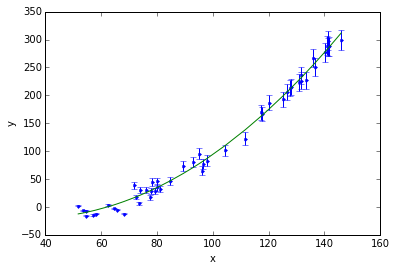

In [81]:
ui.plot_fit('sorted')

In [82]:
plot = ui.get_fit_plot('sorted')

In [83]:
t.assertEqual('', plot.dataplot.title, msg='fit plot: plot title')
t.assertEqual('x', plot.dataplot.xlabel, msg='fit plot: x label')
t.assertEqual('y', plot.dataplot.ylabel, msg='fit plot: y label')

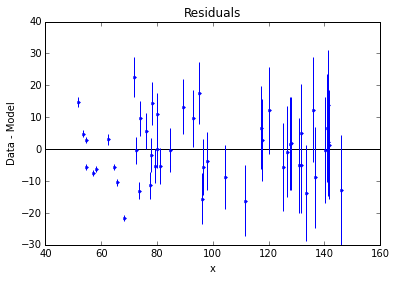

In [84]:
ui.plot_resid('sorted')

In [85]:
plot = ui.get_resid_plot()

In [86]:
t.assertEqual('Residuals', plot.title, msg='residual plot: plot title')
t.assertEqual('x', plot.xlabel, msg='residual plot: x label')
t.assertEqual('Data - Model', plot.ylabel, msg='residual plot: y label')

## Check fit to both

In [87]:
ui.reset(id=1, model=mdl)
ui.reset(id='sorted', model=mdl2)

In [88]:
# parvals = [par_exp, 0.0, 0.0]
parvals = [1.0, 0.0, 0.0]
t.assertEqual(parvals, mdl.thawedpars, msg='mdl after reset')
t.assertEqual(parvals, mdl2.thawedpars, msg='mdl2 after reset')

In [89]:
ui.fit()

Datasets              = 1, 'sorted'
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 2.34719e+06
Final fit statistic   = 9325.65 at function evaluation 28
Data points           = 100
Degrees of freedom    = 94
Change in statistic   = 2.33786e+06
   mdl.c0         11.7278     
   mdl.c1         -1.8543     
   mdl.c2         0.0267718   
   mdl2.c0        11.7278     
   mdl2.c1        -1.8543     
   mdl2.c2        0.0267718   


INFO:sherpa.ui.utils:Datasets              = 1, 'sorted'
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 2.34719e+06
Final fit statistic   = 9325.65 at function evaluation 28
Data points           = 100
Degrees of freedom    = 94
Change in statistic   = 2.33786e+06
   mdl.c0         11.7278     
   mdl.c1         -1.8543     
   mdl.c2         0.0267718   
   mdl2.c0        11.7278     
   mdl2.c1        -1.8543     
   mdl2.c2        0.0267718   


In [90]:
fall = ui.get_fit_results()

In [91]:
t.assertEqual((1, 'sorted'), fall.datasets, msg='combined fit')
t.assertEqual(npts * 2 - 6, fall.dof, msg='combined dof')
t.assertEqualTol(2 * par3_stat_val, fall.statval, tol=2e-3, msg='combined stat')

In [92]:
t.assertEqualTol(a0_fit, mdl.c0.val, tol=a0_tol, msg='combined fit: mdl c0 value')
t.assertEqualTol(a1_fit, mdl.c1.val, tol=a1_tol, msg='combined fit: mdl c1 value')
t.assertEqualTol(a2_fit, mdl.c2.val, tol=a2_tol, msg='combined fit: mdl c2 value')

t.assertEqualTol(a0_fit, mdl2.c0.val, tol=a0_tol, msg='combined fit: mdl2 c0 value')
t.assertEqualTol(a1_fit, mdl2.c1.val, tol=a1_tol, msg='combined fit: mdl2 c1 value')
t.assertEqualTol(a2_fit, mdl2.c2.val, tol=a2_tol, msg='combined fit: mdl2 c2 value')

## How about errors?

None of the "chi square" variants in Sherpa 4.8 are useful here, so supply an error array,
which "magically" has the correct value.

In [93]:
errs = np.zeros_like(ysort) + sigma

In [94]:
ui.set_staterror('sorted', errs)
ui.set_stat('chi2')

In [95]:
t.assertEqual('chi2', ui.get_stat_name())

In [96]:
ui.reset(id='sorted', model=mdl2)

In [97]:
# After the reset, the model evaluates to 1
exp_stat_chi = (((ysort - 1.0) / errs)**2).sum()
t.assertEqualTol(exp_stat_chi, ui.calc_stat('sorted'), msg='chi square statistic (starting value)')

In [98]:
ui.fit('sorted')

Dataset               = sorted
Method                = levmar
Statistic             = chi2
Initial fit statistic = 11735.9
Final fit statistic   = 46.6282 at function evaluation 16
Data points           = 50
Degrees of freedom    = 47
Probability [Q-value] = 0.487862
Reduced statistic     = 0.99209
Change in statistic   = 11689.3
   mdl2.c0        11.7278     
   mdl2.c1        -1.8543     
   mdl2.c2        0.0267718   


INFO:sherpa.ui.utils:Dataset               = sorted
Method                = levmar
Statistic             = chi2
Initial fit statistic = 11735.9
Final fit statistic   = 46.6282 at function evaluation 16
Data points           = 50
Degrees of freedom    = 47
Probability [Q-value] = 0.487862
Reduced statistic     = 0.99209
Change in statistic   = 11689.3
   mdl2.c0        11.7278     
   mdl2.c1        -1.8543     
   mdl2.c2        0.0267718   


In [99]:
fsort = ui.get_fit_results()

In [100]:
t.assertTrue(fsort.succeeded, msg='chi2 fit succeeded')
t.assertEqual('chi2', fsort.statname, msg='fit used chi2')

In [101]:
# We would hope to get a reduced chi-square of 1 here, since the errors are "perfect"
t.assertEqualTol(1.0, fsort.rstat, tol=0.01, msg="reduced chi square from fit")

In [102]:
# As the errors are all the same, the result should be the same as the least squares
# result
t.assertEqualTol(a0_fit, mdl2.c0.val, tol=a0_tol, msg='fit chi2: c0 value')
t.assertEqualTol(a1_fit, mdl2.c1.val, tol=a1_tol, msg='fit chi2: c1 value')
t.assertEqualTol(a2_fit, mdl2.c2.val, tol=a2_tol, msg='fit chi2: c2 value')

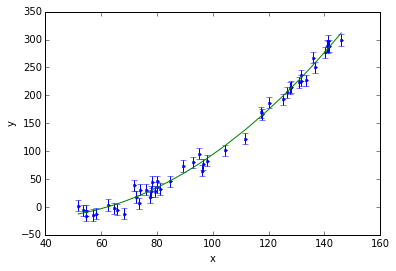

In [103]:
ui.plot_fit('sorted')

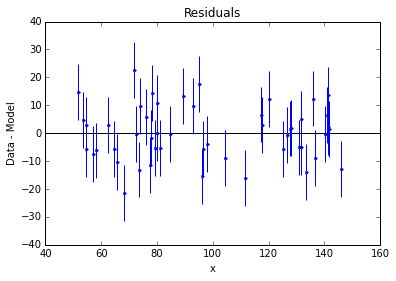

In [104]:
ui.plot_resid('sorted')

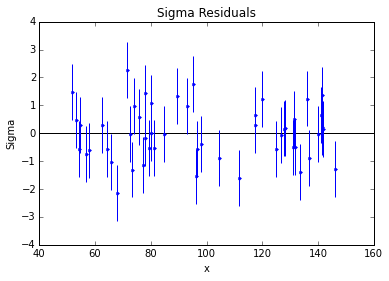

In [105]:
# Can now plot "delchi"
ui.plot_delchi('sorted')

In [106]:
plot = ui.get_delchi_plot('sorted')
t.assertEqual('Sigma Residuals', plot.title, msg='delchi plot: title')
t.assertEqual('x', plot.xlabel, msg='delchi plot: x axis')
t.assertEqual('Sigma', plot.ylabel, msg='delchi plot: y axis')

In [107]:
ui.covar('sorted')

Dataset               = sorted
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   mdl2.c0           11.7278     -19.5753      19.5753
   mdl2.c1           -1.8543    -0.421558     0.421558
   mdl2.c2         0.0267718  -0.00210099   0.00210099


INFO:sherpa.ui.utils:Dataset               = sorted
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   mdl2.c0           11.7278     -19.5753      19.5753
   mdl2.c1           -1.8543    -0.421558     0.421558
   mdl2.c2         0.0267718  -0.00210099   0.00210099


In [108]:
cov = ui.get_covar_results()

In [109]:
onesig = 68.268949
t.assertEqualTol(onesig, cov.percent, tol=1e-6, msg='covar errors are 1 sigma')
t.assertEqual(('mdl2.c0', 'mdl2.c1', 'mdl2.c2'), cov.parnames, msg='covar works on the correct parameters')

parvals = np.asarray([a0_fit, a1_fit, a2_fit])
partol = np.max([a0_tol, a1_tol, a2_tol])
t.assertEqualTol(parvals, np.asarray(cov.parvals), tol=partol, msg='covar is using the correct position')

parmaxs = np.asarray([19.575257, 0.421558, 0.002101])
parmins = -1 * parmaxs
t.assertEqualTol(parmins, np.asarray(cov.parmins), tol=partol, msg='covar min vals')
t.assertEqualTol(parmaxs, np.asarray(cov.parmaxes), tol=partol, msg='covar max vals')

In [110]:
ui.conf('sorted')

Dataset               = sorted
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   mdl2.c0           11.7278     -19.5753      19.5753
   mdl2.c1           -1.8543    -0.421558     0.421558
   mdl2.c2         0.0267718  -0.00210099   0.00210099
mdl2.c0 lower bound:	-19.5753
mdl2.c1 lower bound:	-0.421558
mdl2.c2 lower bound:	-0.00210099
mdl2.c0 upper bound:	19.5753
mdl2.c1 upper bound:	0.421558
mdl2.c2 upper bound:	0.00210099


INFO:sherpa.ui.utils:Dataset               = sorted
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   mdl2.c0           11.7278     -19.5753      19.5753
   mdl2.c1           -1.8543    -0.421558     0.421558
   mdl2.c2         0.0267718  -0.00210099   0.00210099
INFO:sherpa:mdl2.c0 lower bound:	-19.5753
INFO:sherpa:mdl2.c1 lower bound:	-0.421558
INFO:sherpa:mdl2.c2 lower bound:	-0.00210099
INFO:sherpa:mdl2.c0 upper bound:	19.5753
INFO:sherpa:mdl2.c1 upper bound:	0.421558
INFO:sherpa:mdl2.c2 upper bound:	0.00210099


In [111]:
conf = ui.get_conf_results()

In [112]:
# In this case I expect the covariance and confidence methods to give
# very similar answers
t.assertEqualTol(onesig, conf.percent, tol=1e-6, msg='conf errors are 1 sigma')
t.assertEqual(('mdl2.c0', 'mdl2.c1', 'mdl2.c2'), cov.parnames, msg='conf works on the correct parameters')

parvals = np.asarray([a0_fit, a1_fit, a2_fit])
partol = np.max([a0_tol, a1_tol, a2_tol])
t.assertEqualTol(parvals, np.asarray(conf.parvals), tol=partol, msg='conf is using the correct position')

parmaxs = np.asarray([19.575257, 0.421558, 0.002101])
parmins = -1 * parmaxs
t.assertEqualTol(parmins, np.asarray(conf.parmins), tol=partol, msg='conf min vals')
t.assertEqualTol(parmaxs, np.asarray(conf.parmaxes), tol=partol, msg='conf max vals')

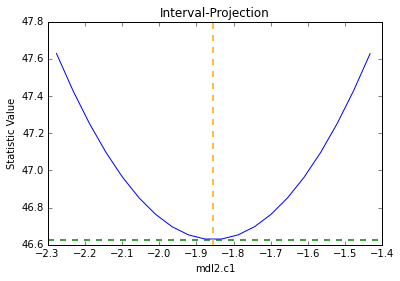

In [113]:
ui.int_proj(mdl2.c1, id='sorted')

In [114]:
iproj = ui.get_int_proj(recalc=False)

In [115]:
t.assertEqual('mdl2.c1', iproj.xlabel, msg='iproj x-axis label')
t.assertEqual('Statistic Value', iproj.ylabel, msg='iproj y-axis label')
# Really should check some numeric values

In [116]:
flag = False
try:
    # should have given an id argument, as id=1 has no staterror column
    ui.reg_proj(mdl2.c0, mdl2.c1, nloop=[41, 41])
except err.StatErr:
    flag = True

t.assertTrue(flag, msg='reg_proj exited with an error')

/home/djburke/miniconda2/envs/sherpa-4.8.0/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


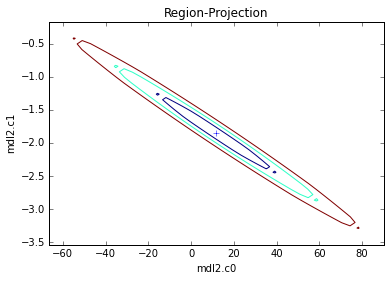

In [117]:
ui.reg_proj(mdl2.c0, mdl2.c1, nloop=[41, 41], id='sorted')

In [118]:
rproj = ui.get_reg_proj(recalc=False)

In [119]:
t.assertEqual('mdl2.c0', rproj.xlabel, msg='rproj x-axis label')
t.assertEqual('mdl2.c1', rproj.ylabel, msg='rproj y-axis label')
# Really should check some numeric values

# Final check

In [120]:
t.report(91)

All 91 tests ran successfully
